## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-indoor' 
TRANSFORM = 'wavelet-vertical'
CHANNEL = 'red'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
red_vertical_wavelet_indoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/indoor/wavelet/vertical/red'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 1604,
 3: 6416,
 4: 25664,
 5: 102656,
 6: 410624,
 7: 1642496,
 8: 6569984,
 9: 26279936}

Running 12760 CDFs


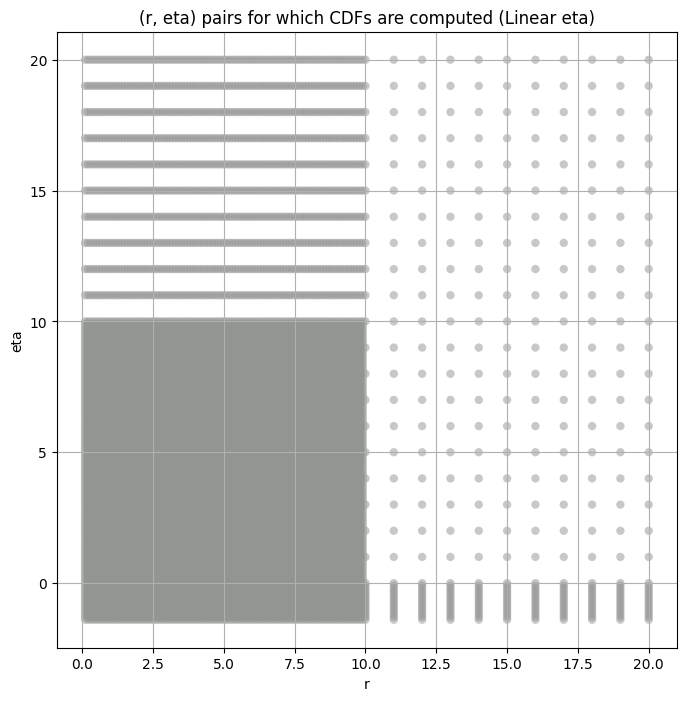

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      2.013948e+07  1.784077e+07  2.261045e+07   1.347482    0.547393   
3      4.751490e+06  4.453670e+06  5.056028e+06   1.871744    1.474008   
4      1.025518e+06  9.638940e+05  1.088946e+06   3.551724    2.970635   
5      2.050262e+05  1.909431e+05  2.196837e+05   5.541098    4.724229   
6      3.674889e+04  3.367524e+04  3.997918e+04   9.241623    7.692896   
7      6.361043e+03  5.725371e+03  7.050686e+03  14.259533   11.564115   
8      1.161078e+03  1.021446e+03  1.315078e+03  21.809298   16.949747   
9      2.461376e+02  2.123457e+02  2.833469e+02  29.576992   22.246300   

       kurt_upper  total_samples  
layer                             
2        2.311735           1604  
3        2.307781           6416  
4        4.214462          25664  
5        6.453926         102656  
6       11.054368         410624  
7       17.877516        1642496  
8       28.048672        6569984  
9       40.071960       26279936

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      2.013948e+07   2.013948e+07    1.521922e+07    1.281783e+07   
3      4.751490e+06   4.751490e+06    4.256110e+06    3.940355e+06   
4      1.025518e+06   1.025518e+06    9.747766e+05    9.393532e+05   
5      2.050262e+05   2.050262e+05    2.009325e+05    1.977716e+05   
6      3.674889e+04   3.674889e+04    3.568431e+04    3.489771e+04   
7      6.361043e+03   6.361043e+03    6.113174e+03    5.935259e+03   
8      1.161078e+03   1.161078e+03    1.098447e+03    1.055016e+03   
9      2.461376e+02   2.461376e+02    2.297101e+02    2.185194e+02   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        1.109017e+07     9.694364e+06     7.511607e+06     5.935626e+06   
3        3.691845e+06     3.476138e+06     3.111524e+06     2.814636e+06   
4        9.101400e+05     8.843905e+05     8.395162e+05     8.009777e+05   
5        1.950025e+05     1.924565e+05     1.878518e+05     1.837182e+05   
6        3.421945e+04     3.360989e+04     3.253636e+04     3.159426e+04   
7        5.782271e+03     5.647042e+03     5.411766e+03     5.208863e+03   
8        1.019093e+03     9.880016e+02     9.351106e+02     8.905788e+02   
9        2.093943e+02     2.015752e+02     1.885421e+02     1.778143e+02   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2         4.683248e+06     3.697280e+06     2.893041e+06     1.187307e+06  
3         2.563831e+06     2.348819e+06     2.160318e+06     1.709232e+06  
4         7.669520e+05     7.365641e+05     7.094714e+05     6.401644e+05  
5         1.799309e+05     1.764316e+05     1.731520e+05     1.644543e+05  
6         3.074694e+04     2.997414e+04     2.925779e+04     2.736469e+04  
7         5.028969e+03     4.866356e+03     4.718440e+03     4.338018e+03  
8         8.519579e+02     8.176899e+02     7.868023e+02     7.089566e+02  
9         1.686498e+02     1.606471e+02     1.535476e+02     1.360924e+02

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.01328485902873347 20139482.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.0243202769158144 15219218.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.04163299690895325 12817831.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.056555763733052294 11090169.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.07007212561786824 9694364.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.09959312066129034 7511607.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.12493760300871903 5935626.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.14873065876561342 4683247.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.17148067524407618 3697279.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.1965224260466089 2893041.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.278964530061626 1187306.8
Number of samples: 1604, Without approximation : 1604


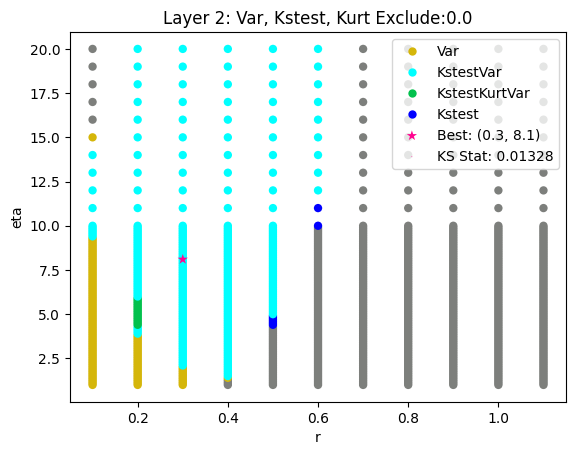

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.009443284534541296 4751489.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.013174119652575492 4256109.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.016995530759159674 3940355.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.021015809865738137 3691845.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.024665226957399873 3476137.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.03144418529705731 3111524.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.03816145373545015 2814636.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.045356560740608065 2563831.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.05440088233134342 2348819.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.06266956425190177 2160318.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.08354601693334228 1709232.0
Number of samples: 6416, Without approximation : 6416


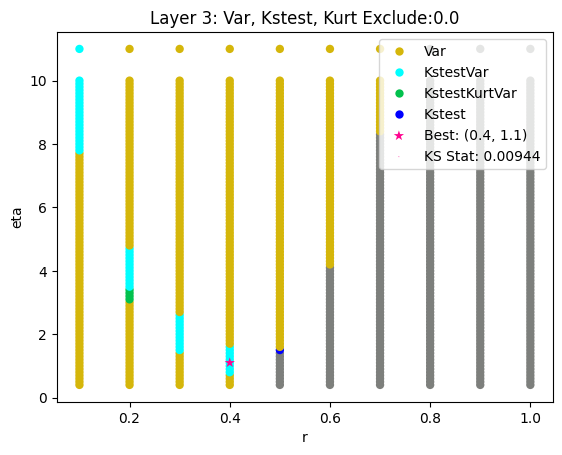

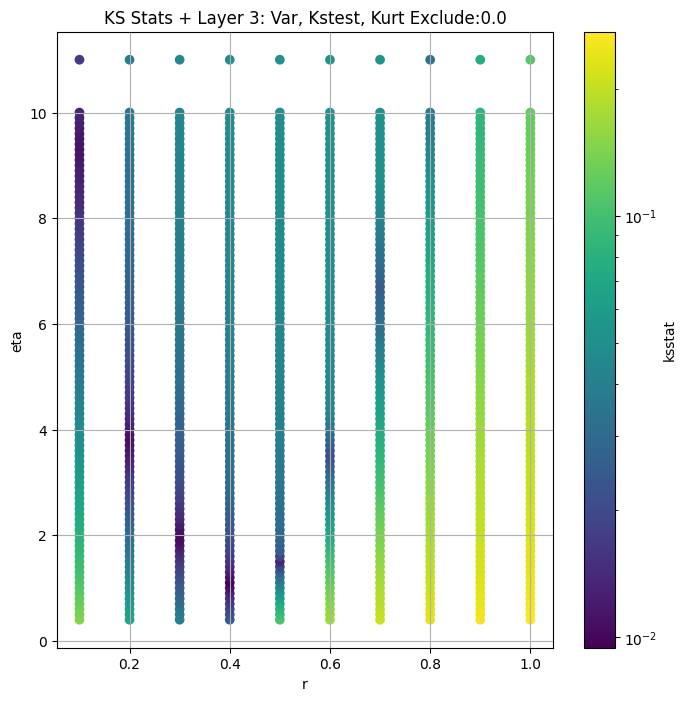

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.01029332561660945 1025518.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.0123929107653451 974776.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.012902112981433955 939353.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.014489802394523466 910140.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.015689225645472704 884390.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.01762605334029843 839516.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.019731285752861094 800977.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.02176881928158303 766952.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.023467230771414327 736564.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.02524341348676773 709471.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.03071169130460316 640164.44
Number of samples: 25664, Without approximation : 25664


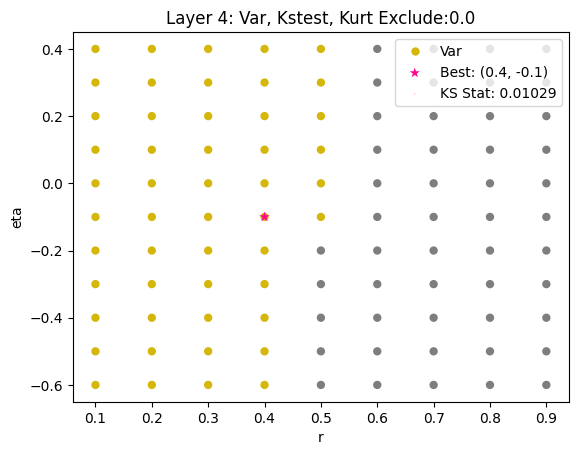

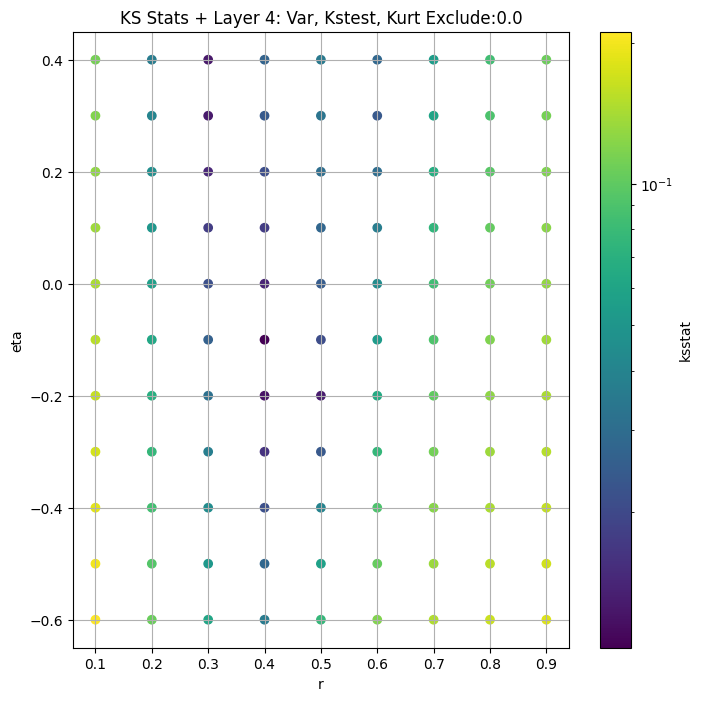

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.010498996151317552 205026.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.0095456811583432 200932.45


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.00889400034027854 197771.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.009710519057244515 195002.48


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.010468653222586943 192456.53


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.011898193277328106 187851.84


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.01322143564473921 183718.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.014478078087296509 179930.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.013930108440959432 176431.61


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.013044765605876307 173151.98


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.015068901887866581 164454.28
Number of samples: 100000, Without approximation : 102656


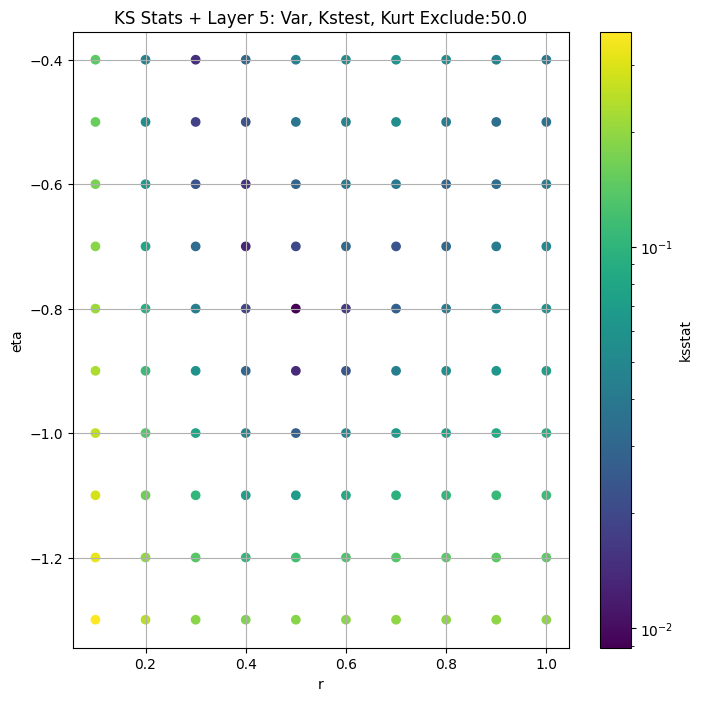

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.01281513759894265 36748.89


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.014314322524931061 35684.31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.014296487640736544 34897.715


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.013737477186252955 34219.45


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.012884441877628938 33609.89


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.011335216591495834 32536.36


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.010477453311727822 31594.26


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.011666136156323503 30746.943


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.012865129321058003 29974.14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.014011762770445246 29257.795


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.014004195574870315 27364.688
Number of samples: 100000, Without approximation : 410624


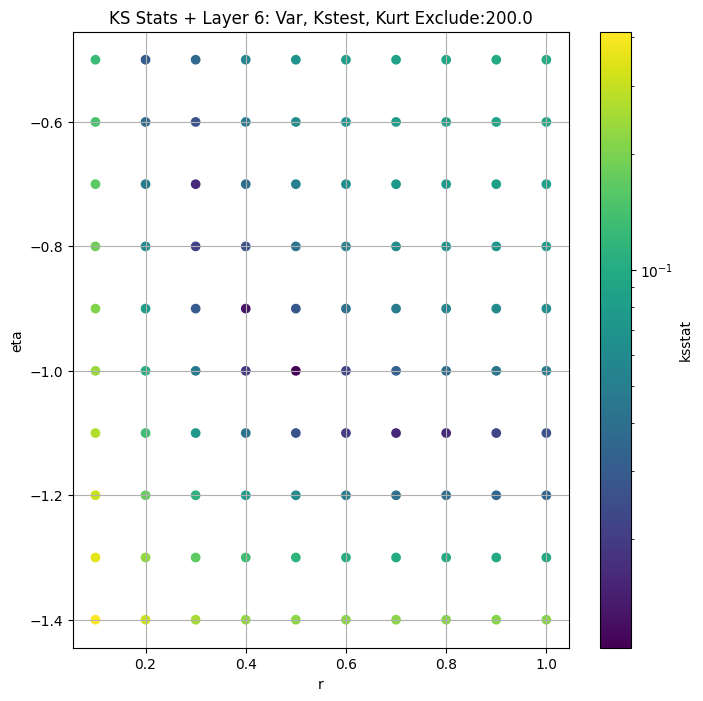

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.021533801063143287 6361.043


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.021097430522441674 6113.1743


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.020783127435371307 5935.2593


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.02050287218314717 5782.2715


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.020246843948364013 5647.0415


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.019783291789923385 5411.7656


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.01952198624164403 5208.863


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.020857331053305228 5028.9688


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.022028347005599858 4866.356


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.021604094135894814 4718.4404


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.021160741288072216 4338.0176
Number of samples: 100000, Without approximation : 1642496


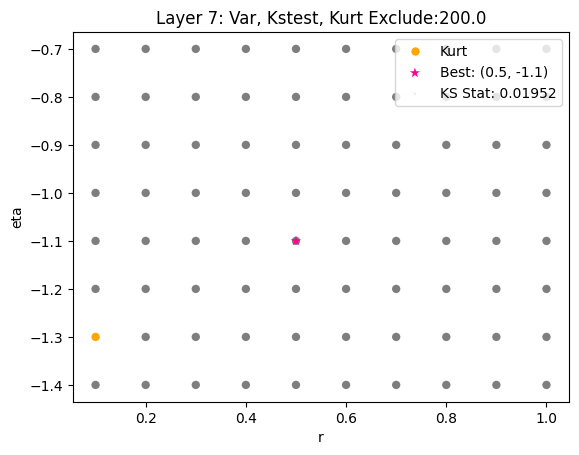

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.007312616292850405 1161.0775


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.0051011600519511174 1098.4471


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.006248198613940527 1055.016


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.007321764655205412 1019.09314


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.008325460260583006 988.0016


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.009048961718583715 935.1106


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.009271036831841939 890.5788


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.007709994908675622 851.9579


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.008775889421112348 817.6899


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.009847698609718458 786.8023


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.010335929567189654 708.9566
Number of samples: 100000, Without approximation : 6569984


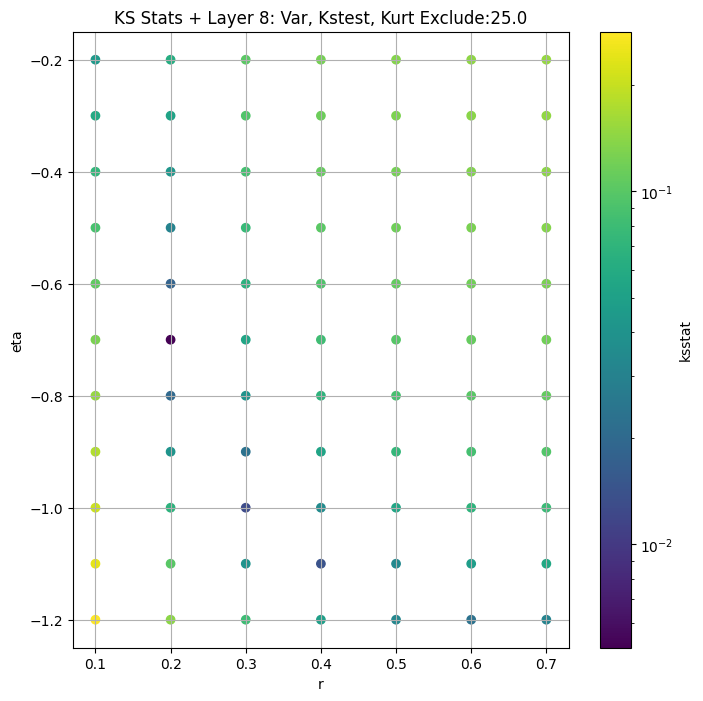

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.015217244916620076 246.13762


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.01430762721003942 229.71013


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.016048703993882252 218.51936


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.017249829889999402 209.39433


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.016026037851412545 201.57521


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.0177955350693062 188.54207


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.01544283110930833 177.81427


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.016054288323282484 168.64981


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.01669269026926723 160.64708


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.01734757296003797 153.5476


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.017486916497910565 136.09238
Number of samples: 100000, Without approximation : 26279936


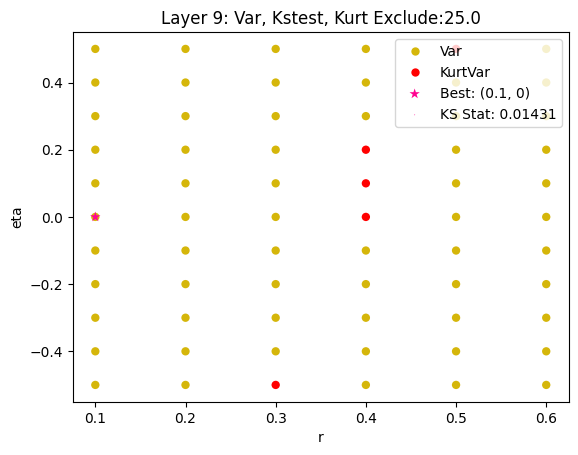

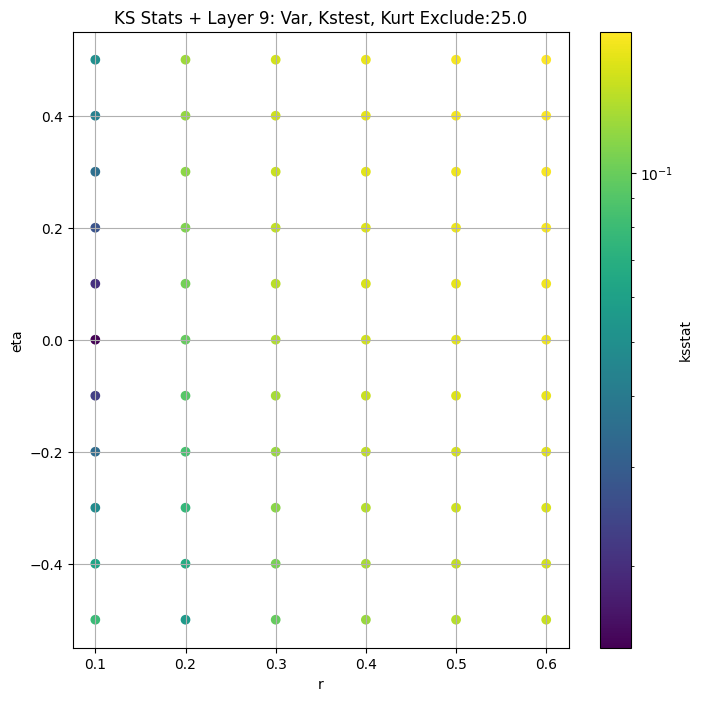

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      2.013948e+07  1.784077e+07  2.261045e+07   1.347482    0.547393   
3      4.751490e+06  4.453670e+06  5.056028e+06   1.871744    1.474008   
4      1.025518e+06  9.638940e+05  1.088946e+06   3.551724    2.970635   
5      2.050262e+05  1.909431e+05  2.196837e+05   5.541098    4.724229   
6      3.674889e+04  3.367524e+04  3.997918e+04   9.241623    7.692896   
7      6.361043e+03  5.725371e+03  7.050686e+03  14.259533   11.564115   
8      1.161078e+03  1.021446e+03  1.315078e+03  21.809298   16.949747   
9      2.461376e+02  2.123457e+02  2.833469e+02  29.576992   22.246300   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.311735           1604             0.013285        0.3          8.1   
3        2.307781           6416             0.009443        0.4          1.1   
4        4.214462          25664             0.010293        0.4         -0.1   
5        6.453926         102656             0.008894        0.5         -0.8   
6       11.054368         410624             0.010477        0.5         -1.0   
7       17.877516        1642496             0.019522        0.5         -1.1   
8       28.048672        6569984             0.005101        0.2         -0.7   
9       40.071960       26279936             0.014308        0.1          0.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       1.720271e+02                     0.0        2.013948e+07   
3       3.392569e+04                     0.0        4.751490e+06   
4       2.840131e+04                     0.0        1.025518e+06   
5       5.886058e+04                    50.0        1.977716e+05   
6       1.579713e+04                   200.0        3.159426e+04   
7       3.617266e+03                   200.0        5.208863e+03   
8       1.634594e-01                    25.0        1.098447e+03   
9       3.227623e-11                    25.0        2.297101e+02   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.033804  
3                     0.016929  
4                     0.008471  
5                     0.004237  
6                     0.002119  
7                     0.001060  
8                     0.000530  
9                     0.000265

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.07483551640050712, var: 9694364.0


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.0595312864113301, var: 11090169.0


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.04453194412146495, var: 12817831.0


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.026772203386500368, var: 15219218.0


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.01294865614530799, var: 20139482.0
Number of samples: 1604, Without approximation : 1604


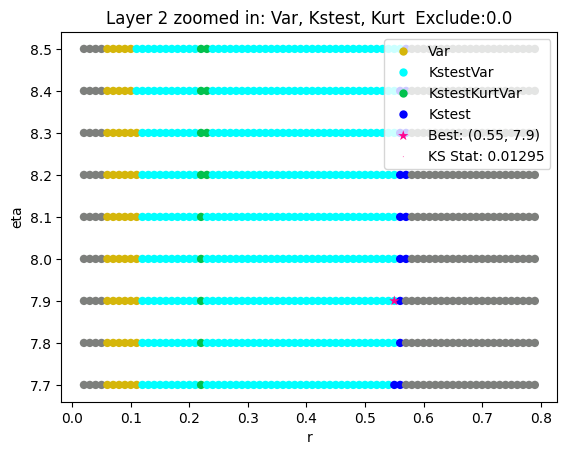

Layer 3


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.03015081260075994, var: 3476137.75


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.024613950385542677, var: 3691845.25


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.018863334976454996, var: 3940355.25


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.012704625777255563, var: 4256109.5


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.009443284534541296, var: 4751489.5
Number of samples: 6416, Without approximation : 6416


Layer 4


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.015064584214020349, var: 884390.5


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.013958400368126012, var: 910140.0


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.012561676770370234, var: 939353.1875


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.011375892736609217, var: 974776.625


  0%|          | 0/1224 [00:00<?, ?it/s]

Finding Minimum after computing 1224 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.009353195487943777, var: 1025518.1875
Number of samples: 25664, Without approximation : 25664


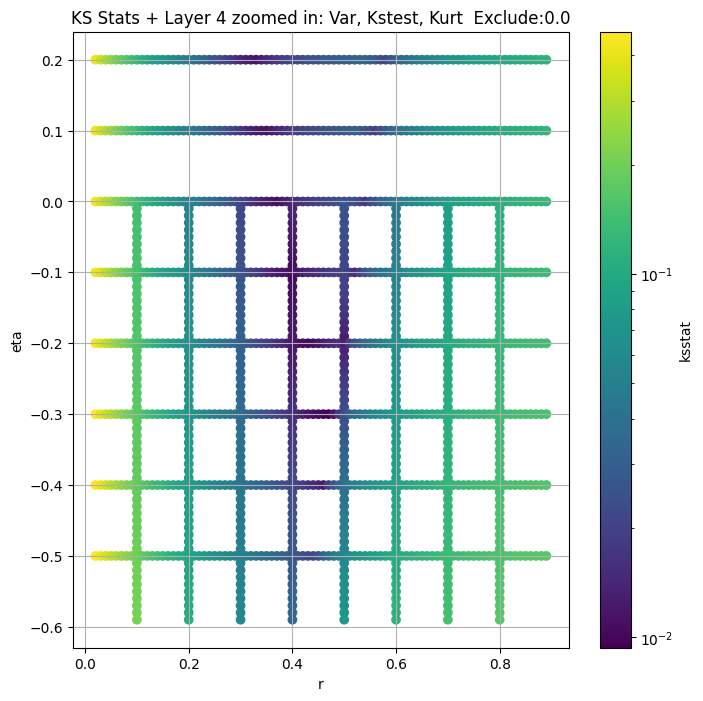

Layer 5


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 50.0 + 100 = 150, ksstat: 0.010275274686852853, var: 187851.84375


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 50.0 + 75 = 125, ksstat: 0.010098507793632416, var: 190084.5


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 50.0 + 50 = 100, ksstat: 0.009912703849866755, var: 192456.53125


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 50.0 + 25 = 75, ksstat: 0.009365687194691552, var: 195002.484375


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 50.0 + 0 = 50, ksstat: 0.00889400034027854, var: 197771.5625


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 50.0 + -25 = 25, ksstat: 0.008304015462308967, var: 200932.453125


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 50.0 + -50 = 0, ksstat: 0.00782791472713229, var: 205026.203125
Number of samples: 100000, Without approximation : 102656


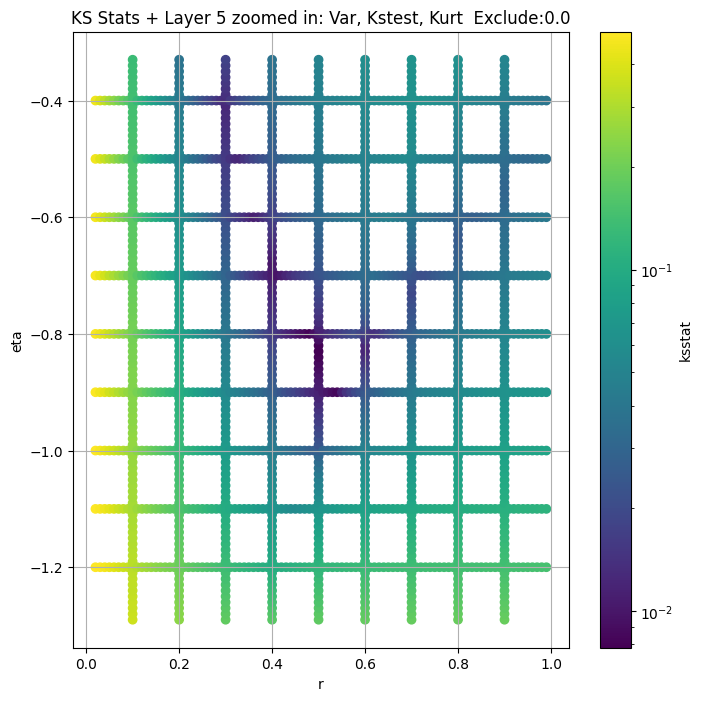

Layer 6


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + 100 = 300, ksstat: 0.011199974826203052, var: 29974.140625


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + 75 = 275, ksstat: 0.011401211532269383, var: 30352.548828125


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + 50 = 250, ksstat: 0.011241725137994506, var: 30746.943359375


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + 25 = 225, ksstat: 0.010775403119064775, var: 31160.013671875


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + 0 = 200, ksstat: 0.010477453311727822, var: 31594.259765625


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + -25 = 175, ksstat: 0.01030043714061439, var: 32051.603515625


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + -50 = 150, ksstat: 0.009957202890698014, var: 32536.359375


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + -75 = 125, ksstat: 0.010347875948344964, var: 33053.08203125


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 200.0 + -100 = 100, ksstat: 0.010096247890126586, var: 33609.890625
Number of samples: 100000, Without approximation : 410624


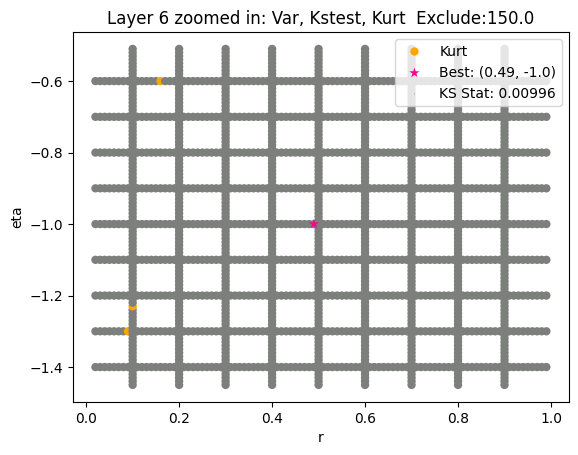

Layer 7


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 200.0 + 100 = 300, ksstat: 0.017647726115404216, var: 4866.35595703125


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 200.0 + 75 = 275, ksstat: 0.017799757659789806, var: 4945.6513671875


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 200.0 + 50 = 250, ksstat: 0.018175560069068175, var: 5028.96875


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 200.0 + 25 = 225, ksstat: 0.018365026346751134, var: 5116.46044921875


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 200.0 + 0 = 200, ksstat: 0.018549930979369522, var: 5208.86279296875


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 200.0 + -25 = 175, ksstat: 0.018763138867295026, var: 5306.90625


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 200.0 + -50 = 150, ksstat: 0.0186211316142324, var: 5411.765625


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 200.0 + -75 = 125, ksstat: 0.017878357460309968, var: 5524.5859375


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 200.0 + -100 = 100, ksstat: 0.017996443278840868, var: 5647.04150390625
Number of samples: 100000, Without approximation : 1642496


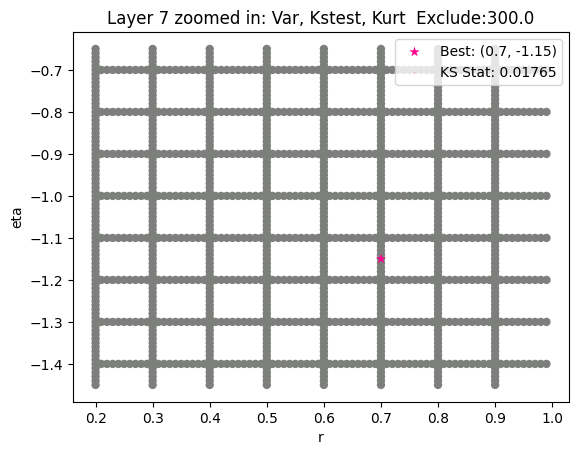

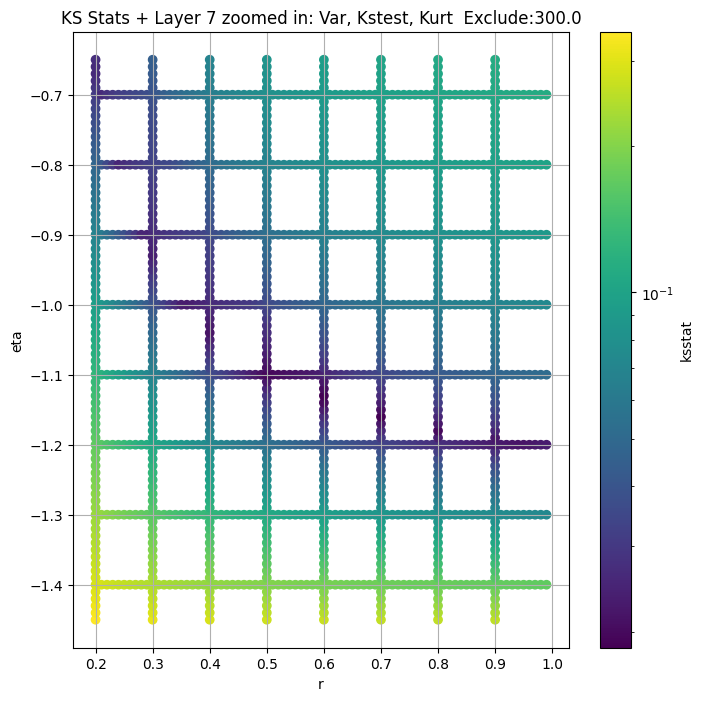

Layer 8


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 25.0 + 100 = 125, ksstat: 0.006665673547311714, var: 960.259033203125


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 25.0 + 75 = 100, ksstat: 0.006335756665911185, var: 988.0015869140625


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 25.0 + 50 = 75, ksstat: 0.005922097601493023, var: 1019.0931396484375


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 25.0 + 25 = 50, ksstat: 0.005023321368033046, var: 1055.0159912109375


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 25.0 + 0 = 25, ksstat: 0.0051011600519511174, var: 1098.4471435546875


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 25.0 + -25 = 0, ksstat: 0.004448365122884823, var: 1161.0775146484375
Number of samples: 100000, Without approximation : 6569984


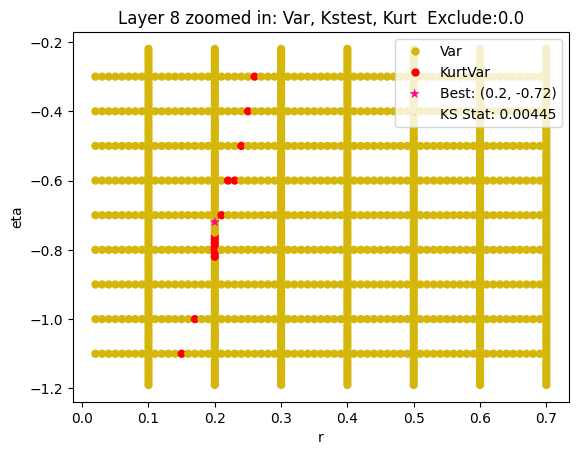

Layer 9


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 9, 25.0 + 100 = 125, ksstat: 0.014335795135534513, var: 194.70237731933594


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 9, 25.0 + 75 = 100, ksstat: 0.014362499745751933, var: 201.57521057128906


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 9, 25.0 + 50 = 75, ksstat: 0.014071705589027705, var: 209.3943328857422


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 9, 25.0 + 25 = 50, ksstat: 0.015001905365545243, var: 218.5193634033203


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 9, 25.0 + 0 = 25, ksstat: 0.01430762721003942, var: 229.7101287841797


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 9, 25.0 + -25 = 0, ksstat: 0.014167601142717534, var: 246.1376190185547
Number of samples: 100000, Without approximation : 26279936


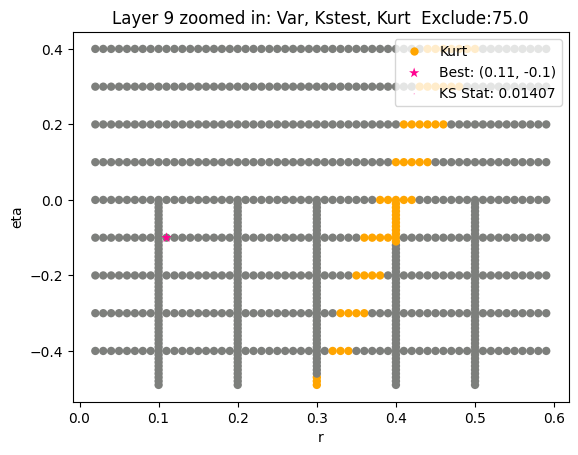

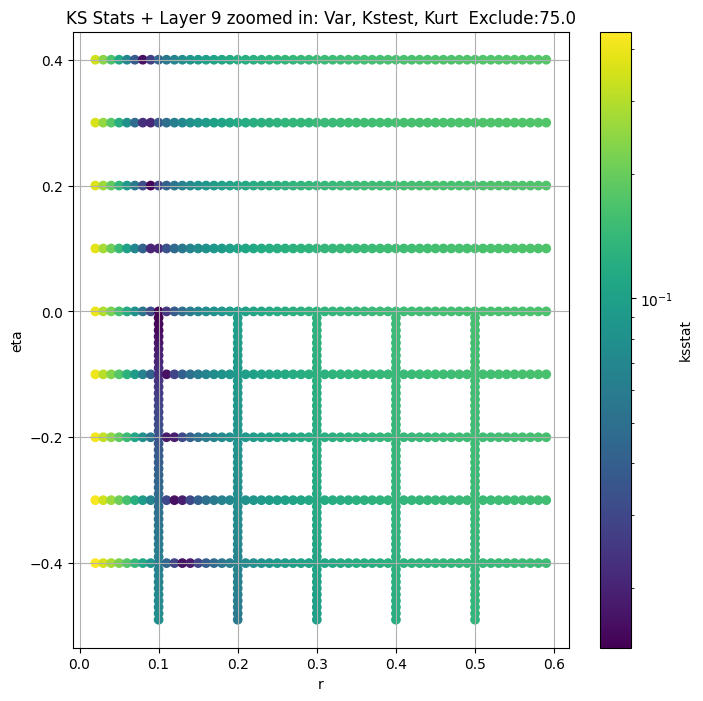

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      2.013948e+07  1.784077e+07  2.261045e+07   1.347482    0.547393   
3      4.751490e+06  4.453670e+06  5.056028e+06   1.871744    1.474008   
4      1.025518e+06  9.638940e+05  1.088946e+06   3.551724    2.970635   
5      2.050262e+05  1.909431e+05  2.196837e+05   5.541098    4.724229   
6      3.674889e+04  3.367524e+04  3.997918e+04   9.241623    7.692896   
7      6.361043e+03  5.725371e+03  7.050686e+03  14.259533   11.564115   
8      1.161078e+03  1.021446e+03  1.315078e+03  21.809298   16.949747   
9      2.461376e+02  2.123457e+02  2.833469e+02  29.576992   22.246300   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.311735           1604             0.013285        0.3          8.1   
3        2.307781           6416             0.009443        0.4          1.1   
4        4.214462          25664             0.010293        0.4         -0.1   
5        6.453926         102656             0.008894        0.5         -0.8   
6       11.054368         410624             0.010477        0.5         -1.0   
7       17.877516        1642496             0.019522        0.5         -1.1   
8       28.048672        6569984             0.005101        0.2         -0.7   
9       40.071960       26279936             0.014308        0.1          0.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       1.720271e+02                     0.0        2.013948e+07   
3       3.392569e+04                     0.0        4.751490e+06   
4       2.840131e+04                     0.0        1.025518e+06   
5       5.886058e+04                    50.0        2.050262e+05   
6       1.579713e+04                   200.0        3.253636e+04   
7       3.617266e+03                   200.0        4.866356e+03   
8       1.634594e-01                    25.0        1.161078e+03   
9       3.227623e-11                    25.0        2.093943e+02   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.033804          0.012949    0.55      7.90   
3                     0.016929          0.009443    0.40      1.10   
4                     0.008471          0.009353    0.47     -0.30   
5                     0.004237          0.007828    0.50     -0.83   
6                     0.002119          0.009957    0.49     -1.00   
7                     0.001060          0.017648    0.70     -1.15   
8                     0.000530          0.004448    0.20     -0.72   
9                     0.000265          0.014072    0.11     -0.10   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      1.000000e+05                  0.0        11556  
3      3.392569e+04                  0.0        21654  
4      9.433030e+04                  0.0        21654  
5      6.538659e+04                  0.0        28872  
6      1.518851e+04                150.0        19248  
7      8.875005e+03                300.0         6088  
8      1.889176e-01                  0.0        97443  
9      1.725854e-09                 75.0         9624

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

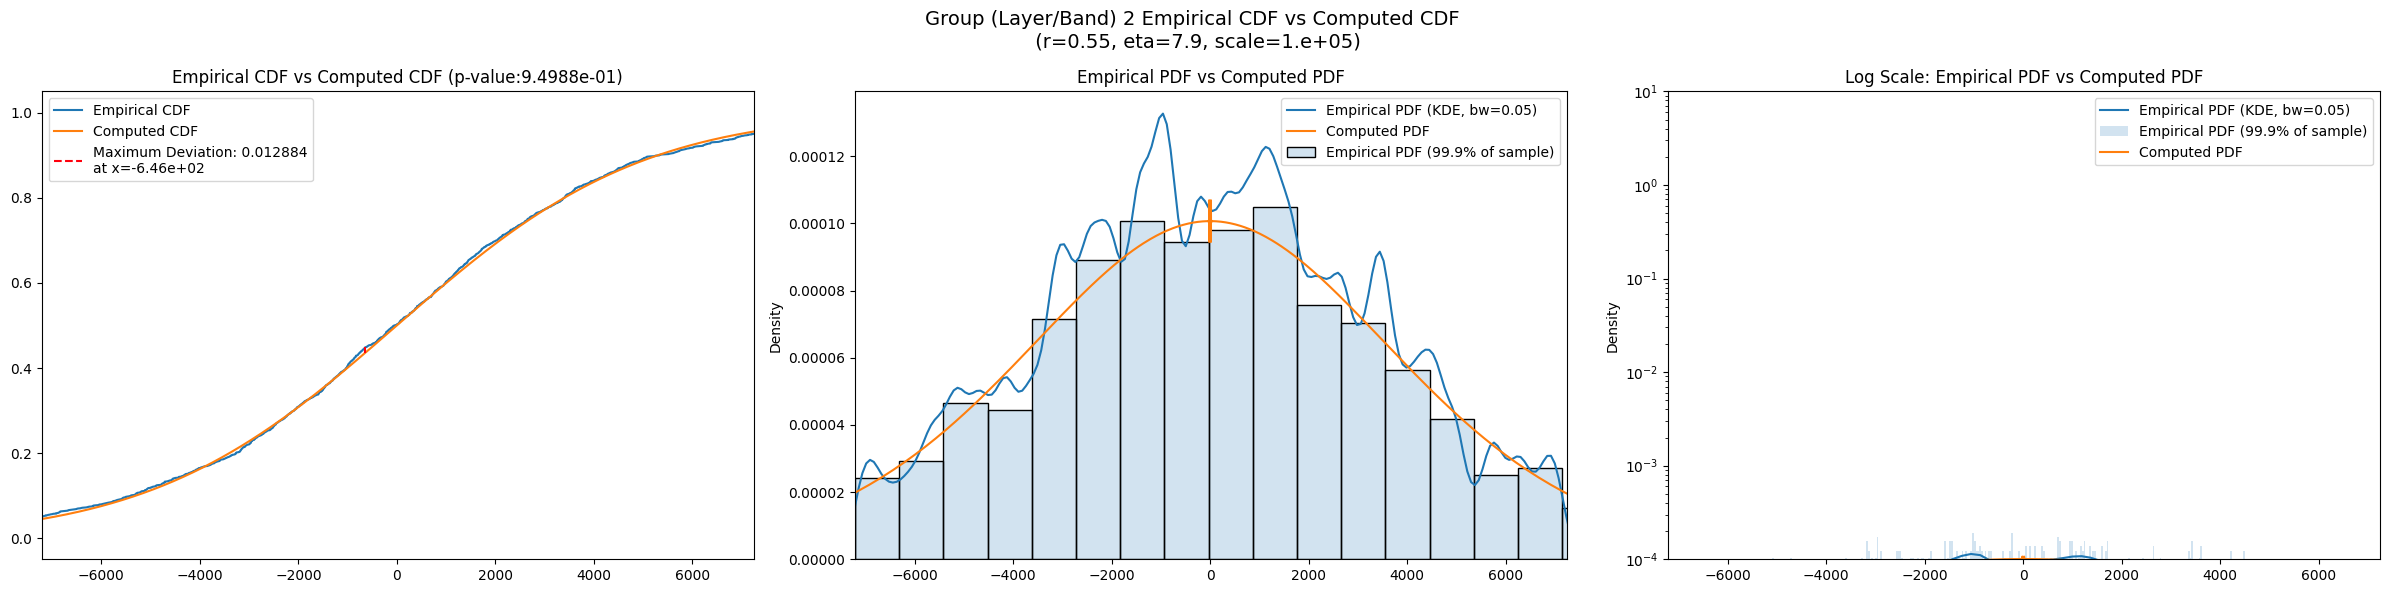

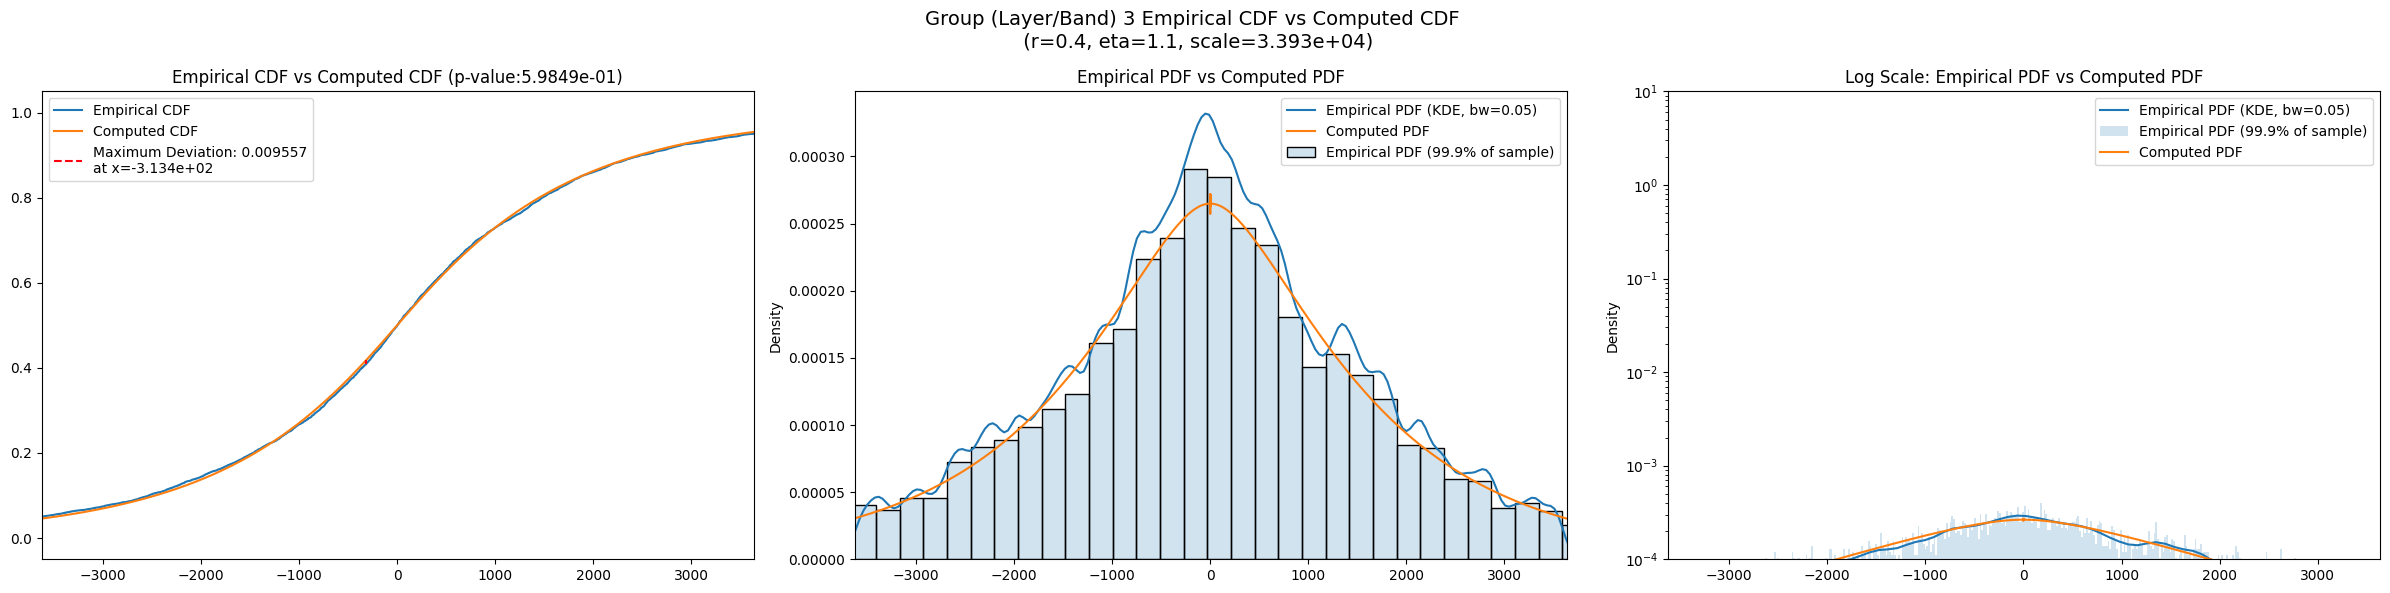

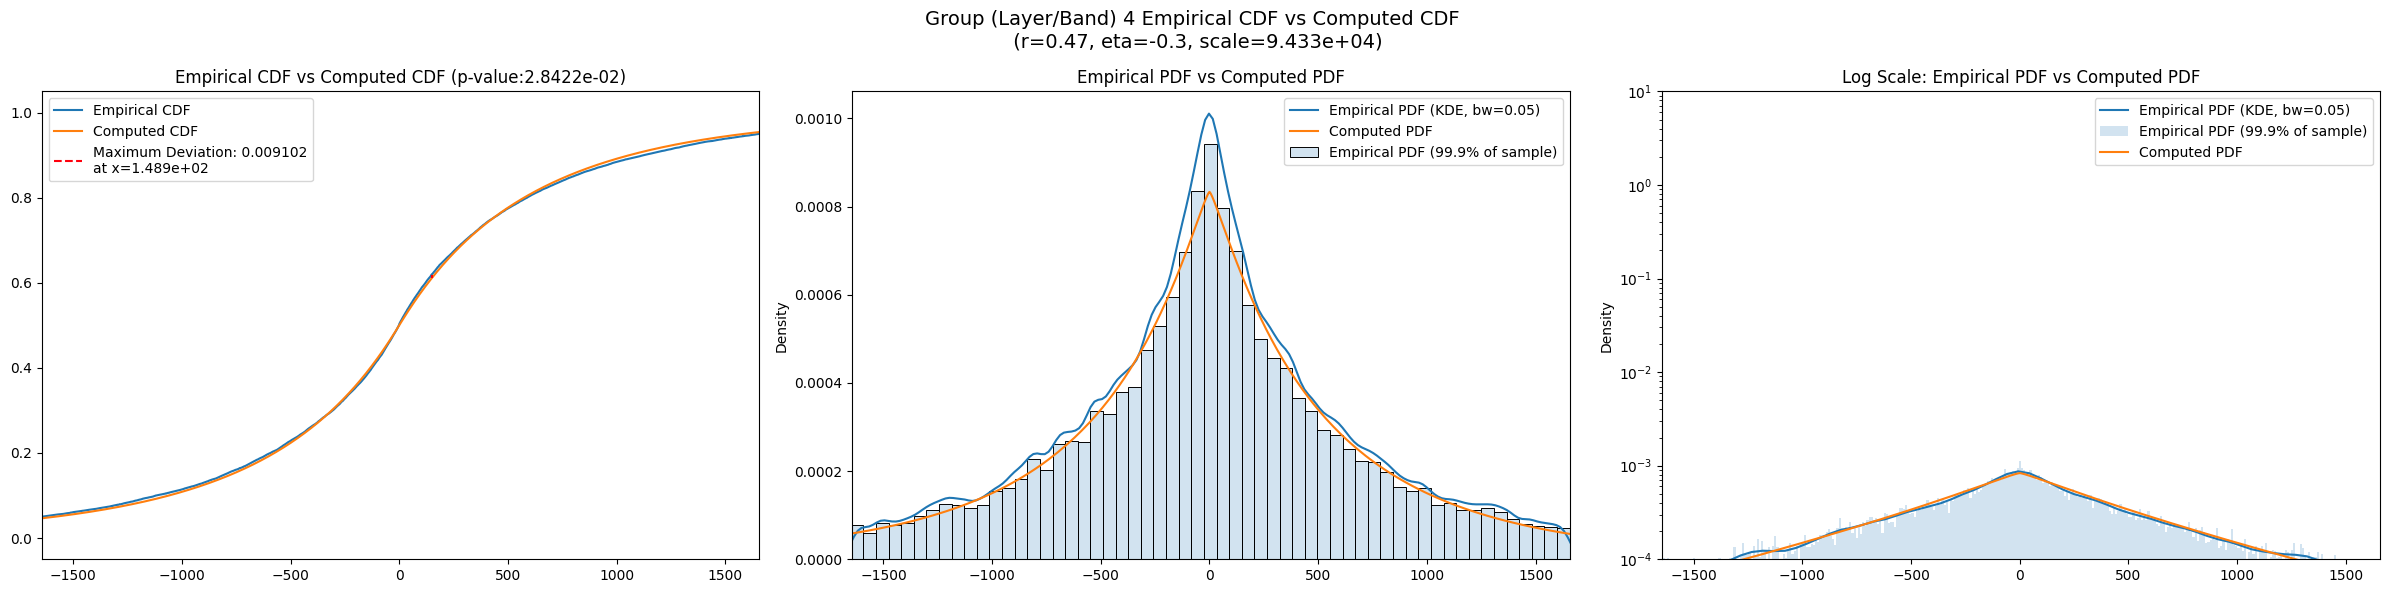

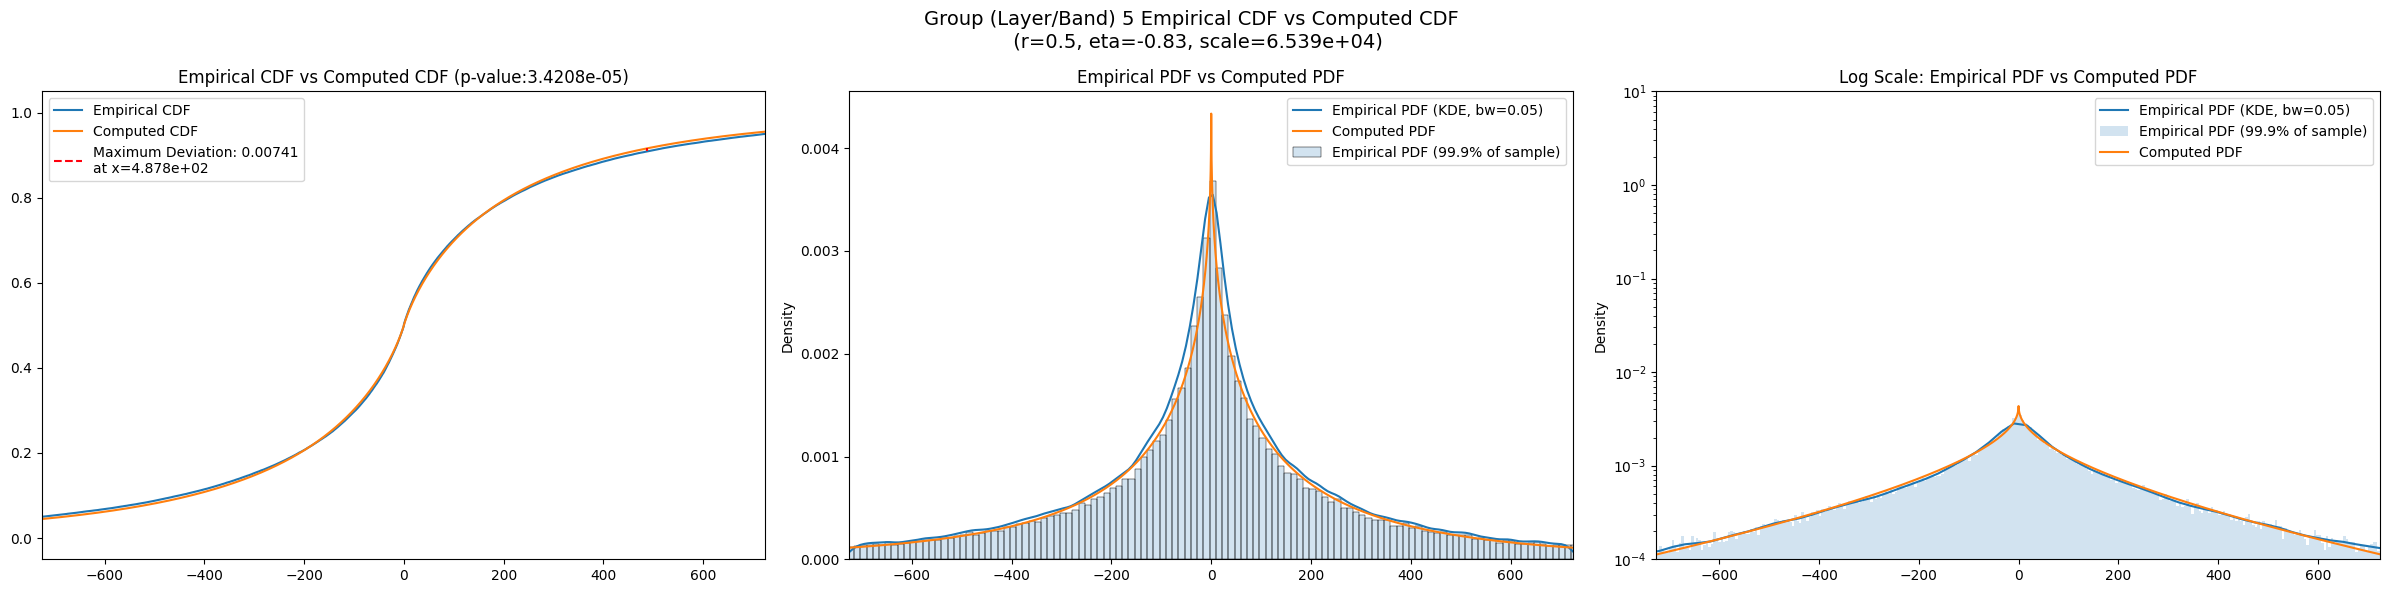

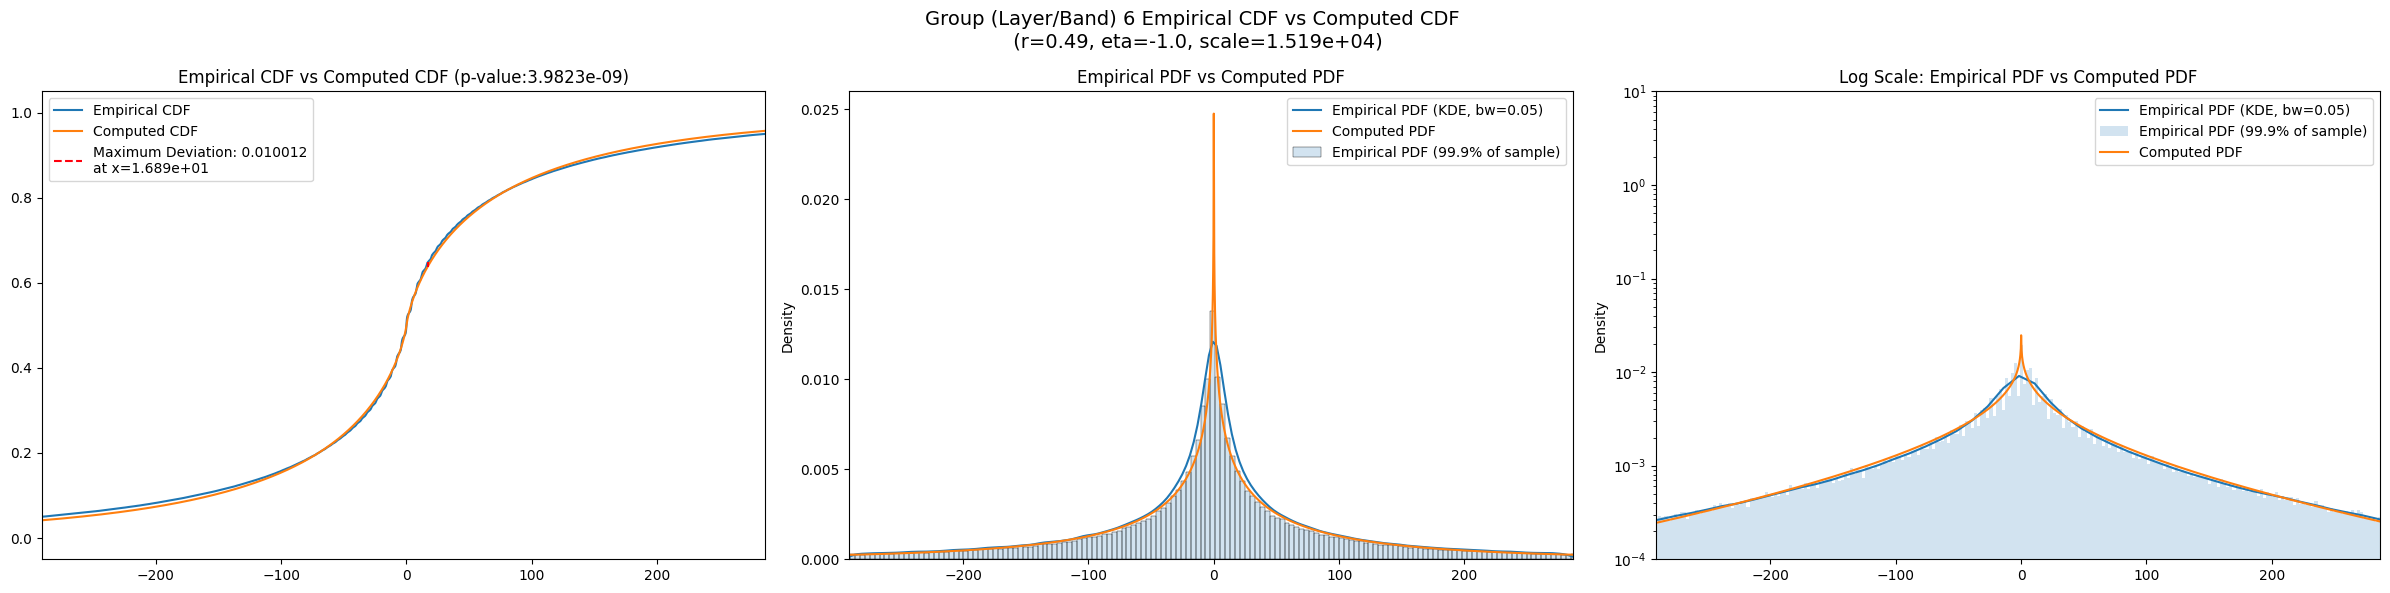

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      2.013948e+07  1.784077e+07  2.261045e+07   1.347482    0.547393   
3      4.751490e+06  4.453670e+06  5.056028e+06   1.871744    1.474008   
4      1.025518e+06  9.638940e+05  1.088946e+06   3.551724    2.970635   
5      2.050262e+05  1.909431e+05  2.196837e+05   5.541098    4.724229   
6      3.674889e+04  3.367524e+04  3.997918e+04   9.241623    7.692896   
7      6.361043e+03  5.725371e+03  7.050686e+03  14.259533   11.564115   
8      1.161078e+03  1.021446e+03  1.315078e+03  21.809298   16.949747   
9      2.461376e+02  2.123457e+02  2.833469e+02  29.576992   22.246300   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.311735           1604             0.013285        0.3          8.1   
3        2.307781           6416             0.009443        0.4          1.1   
4        4.214462          25664             0.010293        0.4         -0.1   
5        6.453926         102656             0.008894        0.5         -0.8   
6       11.054368         410624             0.010477        0.5         -1.0   
7       17.877516        1642496             0.019522        0.5         -1.1   
8       28.048672        6569984             0.005101        0.2         -0.7   
9       40.071960       26279936             0.014308        0.1          0.0   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...      4105.10000              0.016794          7.495750e-01   
3      ...      1810.13000              0.029967          1.936160e-05   
4      ...       735.95500              0.042287          2.584930e-40   
5      ...       265.47600              0.059226                   NaN   
6      ...        87.83680              0.073120          0.000000e+00   
7      ...        29.39990              0.078356          0.000000e+00   
8      ...        11.55510              0.072720          0.000000e+00   
9      ...         4.43411              0.082131          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
layer                                                                        
2         3795.54000             0.027256         1.810370e-01  2958.33000   
3         1613.14000             0.007423         8.686630e-01  1331.66000   
4          639.04600             0.015783         5.534980e-06   520.04800   
5          230.55100             0.032287         2.097240e-93   183.79000   
6           75.58950             0.047461         0.000000e+00    59.24260   
7           25.42740             0.053219         0.000000e+00    19.76210   
8           10.18400             0.046894         0.000000e+00     7.82983   
9            3.87168             0.056023         0.000000e+00     3.00080   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.026353   2.115170e-01          9.475638e-01  
3           0.014421   1.373110e-01          6.129173e-01  
4           0.020082   2.018330e-09          2.229425e-02  
5           0.035101  2.527860e-110          6.838345e-06  
6           0.048800   0.000000e+00          8.623222e-36  
7           0.052941   0.000000e+00          0.000000e+00  
8           0.045751   0.000000e+00         2.385092e-113  
9           0.056279   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.013285                 0.033804          0.012949   
3                 0.009443                 0.016929          0.009443   
4                 0.010293                 0.008471          0.009353   
5                 0.008894                 0.004237          0.007828   
6                 0.010477                 0.002119          0.009957   
7                 0.019522                 0.001060          0.017648   
8                 0.005101                 0.000530          0.004448   
9                 0.014308                 0.000265          0.014072   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.016794             0.027256       0.026353  
3                  0.029967             0.007423       0.014421  
4                  0.042287             0.015783       0.020082  
5                  0.059226             0.032287       0.035101  
6                  0.073120             0.047461       0.048800  
7                  0.078356             0.053219       0.052941  
8                  0.072720             0.046894       0.045751  
9                  0.082131             0.056023       0.056279

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2            2.013948e+07          0.012949    0.55      7.90  1.000000e+05   
3            4.751490e+06          0.009443    0.40      1.10  3.392569e+04   
4            1.025518e+06          0.009353    0.47     -0.30  9.433030e+04   
5            2.050262e+05          0.007828    0.50     -0.83  6.538659e+04   
6            3.253636e+04          0.009957    0.49     -1.00  1.518851e+04   
7            4.866356e+03          0.017648    0.70     -1.15  8.875005e+03   
8            1.161078e+03          0.004448    0.20     -0.72  1.889176e-01   
9            2.093943e+02          0.014072    0.11     -0.10  1.725854e-09   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                    150.0  
7                    300.0  
8                      0.0  
9                     75.0

In [21]:
eng.quit()